# Image Object Detection: Multi-Class Convolutional Neural Network

## Notebook Goals
- use a pre-built set of images from the web
- build & experiment with machine-learning models
- build a multi(_10_)-classification CNN 
- Analyze Model performance

Building A CNN:
- familiarize with the data
- pre-process the data
- decide on model parameters
- create & fit the model
- evaluate model performance
- repeat previous 3 steps (parameters, create, fit, evaluate) to best performance

## Imports

In [4]:
import tensorflow as tf
import zipfile
import os
import pathlib
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

## Beware overfitting
Overfitting can happen when...
- too "large" a number of convolutional layers is present
- too "large" a number of convolutional filters is present
- **the "shape" of the accuracy-over-epochs curve** has changed from going up to flat &/or going down
- **the "shape" of the validation-loss-over-epochs curve** has changed from going down to either "flattening out" or even going up
- a "large" gap between training & validation curves of the same metric

### Preventing Overfitting: Regularization
- use more data
- simplify the model
- use data augmentation
- use transfer learning

## Get Data

In [5]:
# FOOD images!
# based on a HUGE "food101" dataset from kaggle
# https://www.kaggle.com/datasets/dansbecker/food-101
# https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 

fileName = "10_food_classes_all_data"
# Unzip the downloaded file
zip_ref = zipfile.ZipFile(fileName + '.zip', "r")
zip_ref.extractall()
zip_ref.close()

--2024-06-21 22:46:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.80.91, 142.250.80.123, 142.250.176.219, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.80.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.2’

10_food_classes_all 100%[===================>] 495.13M  11.2MB/s    in 62s     

2024-06-21 22:47:52 (7.95 MB/s) - ‘10_food_classes_all_data.zip.2’ saved [519183241/519183241]



### Inspect

In [8]:
# Walk through 10_food_classes directory and list number of files
for dirpath, dirnames, filenames in os.walk(fileName):
    print(f'walk:   {dirpath.split("/")[-1].upper()}')
    if(len(dirnames) > 0):
        print(f'  dirs:     {len(dirnames)}')
    if(len(filenames) > 0):
        print(f'  images:     {len(filenames)}')
    # print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk:   10_FOOD_CLASSES_ALL_DATA
  dirs:     2
walk:   TRAIN
  dirs:     10
walk:   CHICKEN_CURRY
  images:     750
walk:   SUSHI
  images:     750
walk:   GRILLED_SALMON
  images:     750
walk:   CHICKEN_WINGS
  images:     750
walk:   FRIED_RICE
  images:     750
walk:   PIZZA
  images:     750
walk:   ICE_CREAM
  images:     750
walk:   HAMBURGER
  images:     750
walk:   STEAK
  images:     750
walk:   RAMEN
  images:     750
walk:   TEST
  dirs:     10
walk:   CHICKEN_CURRY
  images:     250
walk:   SUSHI
  images:     250
walk:   GRILLED_SALMON
  images:     250
walk:   CHICKEN_WINGS
  images:     250
walk:   FRIED_RICE
  images:     250
walk:   PIZZA
  images:     250
walk:   ICE_CREAM
  images:     250
walk:   HAMBURGER
  images:     250
walk:   STEAK
  images:     250
walk:   RAMEN
  images:     250


### Create Variables

In [9]:
# 
# training & testing directory paths
# 
training_dir_path = fileName + '/train/'
testing_dir_path = fileName + '/test/'
trainingPath = pathlib.Path(training_dir_path)

# 
# classification names in arr
# 
class_names = np.array(sorted([item.name for item in trainingPath.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


### Preview Image(s)

In [10]:
def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (382, 512, 3)


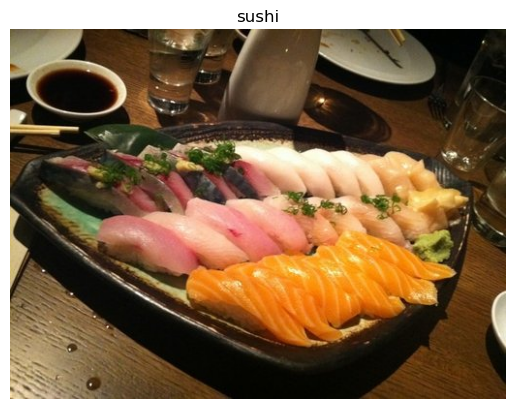

In [11]:
img = view_random_image(target_dir=training_dir_path,
                        target_class=random.choice(class_names)) # get a random class name

### Data Cleanup
- convert training & testing images to tensors
- **SHUFFLE** the images in each directory (training & testing) to remove any patterns learned based on order

In [12]:
# 
# create data-generators 
#   which include re-scaling
# 
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# batchSize = 32
# i get Allocation of 63083520 exceeds 10% of free system memory.
batchSize = 16

# 
# Load images into variables:
#   rescale the output sizes to 244x244
#   store in "batches" of 32 to minimize images-stored-in-memory during training
#   shuffle the data
#   
# 
training_data = train_datagen.flow_from_directory(training_dir_path,
                                               target_size=(224, 224),
                                               batch_size=batchSize,
                                               class_mode='categorical',
                                               shuffle=True)

testing_data = train_datagen.flow_from_directory(testing_dir_path,
                                              target_size=(224, 224),
                                              batch_size=batchSize,
                                              class_mode='categorical',
                                              shuffle=True)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Model: Baseline

In [15]:
# 
# data-driven output unit-count
# 
outputUnitCount = len(class_names)

In [40]:
# 
# Create
# 
# based on the TinyVGG model
# https://github.com/poloclub/cnn-explainer/blob/master/tiny-vgg/tiny-vgg.py#L179
baseline = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(outputUnitCount, activation='softmax') # changed to have 10 neurons (same as number of classes) and 'softmax' activation
])

In [41]:
# 
# Compile
# 
baseline.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [42]:
# 
# FIT
# 
baselineHistory = baseline.fit(training_data,
                        epochs=5,
                        steps_per_epoch=len(training_data),
                        validation_data=testing_data,
                        validation_steps=len(testing_data))

Epoch 1/5
469/469 [==============================] - 1162s 2s/step - loss: 2.1211 - accuracy: 0.2309 - val_loss: 2.0190 - val_accuracy: 0.2760
Epoch 2/5
469/469 [==============================] - 1144s 2s/step - loss: 1.8116 - accuracy: 0.3787 - val_loss: 1.8866 - val_accuracy: 0.3516
Epoch 3/5
469/469 [==============================] - 1137s 2s/step - loss: 1.3938 - accuracy: 0.5377 - val_loss: 1.9821 - val_accuracy: 0.3448
Epoch 4/5
469/469 [==============================] - 1191s 3s/step - loss: 0.7423 - accuracy: 0.7537 - val_loss: 2.6450 - val_accuracy: 0.3220
Epoch 5/5
469/469 [==============================] - 1138s 2s/step - loss: 0.2471 - accuracy: 0.9275 - val_loss: 4.0051 - val_accuracy: 0.2992


### Inspect Results

#### Summary

In [43]:
baseline.summary() 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 110, 110, 10)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_7 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                 

#### Visualize Loss & Accuracy

In [20]:
pd.DataFrame(baselineHistory.history).plot(figsize=(10, 7));

NameError: name 'baselineHistory' is not defined

In [94]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  chartW = 3
  chartH = 3
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochCount = range(len(history.history['loss']))

  plt.figure(figsize=(chartW, chartH))
  plt.ylim(bottom=0) #ymin is your value
  plt.ylim(top=3) #ymin is your value
  # Plot loss
  plt.plot(epochCount, loss, label='training_loss')
  plt.plot(epochCount, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure(figsize=(chartW, chartH))
  plt.ylim(bottom=0) #ymin is your value
  plt.ylim(top=3) #ymin is your value
  plt.plot(epochCount, accuracy, label='training_accuracy')
  plt.plot(epochCount, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

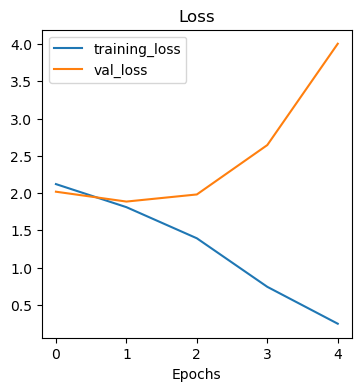

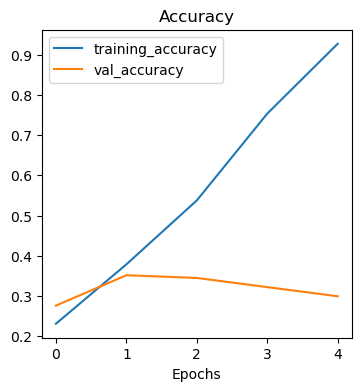

In [63]:
plot_loss_curves(baselineHistory)

#### Analysis Notes
- the `val_accuracy`, or "validation accuracy" looks to be `29`: not very good
- the `val_loss`, or "validation loss", goes up from 2 to 4: this is usually a sign of over-fitting: not good

#### Adjust Model: Change Layers
Try `Conv2d` then `MaxPool2D` alternating?! see if that helps?!

## Model II: Change Layers
Less layers

In [16]:
m2 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(outputUnitCount, activation='softmax') # changed to have 10 neurons (same as number of classes) and 'softmax' activation
])

In [17]:
# 
# Compile
# 
m2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [18]:
# 
# FIT
# 
m2History = m2.fit(training_data,
                        epochs=5,
                        steps_per_epoch=len(training_data),
                        validation_data=testing_data,
                        validation_steps=len(testing_data))

Epoch 1/5
469/469 [==============================] - 458s 970ms/step - loss: 2.1247 - accuracy: 0.2255 - val_loss: 1.9849 - val_accuracy: 0.2704
Epoch 2/5
469/469 [==============================] - 457s 975ms/step - loss: 1.8498 - accuracy: 0.3667 - val_loss: 1.8973 - val_accuracy: 0.3344
Epoch 3/5
469/469 [==============================] - 458s 976ms/step - loss: 1.6350 - accuracy: 0.4421 - val_loss: 1.9469 - val_accuracy: 0.3172
Epoch 4/5
469/469 [==============================] - 494s 1s/step - loss: 1.3526 - accuracy: 0.5449 - val_loss: 2.0256 - val_accuracy: 0.3276
Epoch 5/5
469/469 [==============================] - 457s 973ms/step - loss: 1.0522 - accuracy: 0.6463 - val_loss: 2.3228 - val_accuracy: 0.3272


### Inspect Results
#### Summary

In [19]:
m2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 10)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 10)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 26, 26, 10)        0

#### Visualize Loss & Accuracy

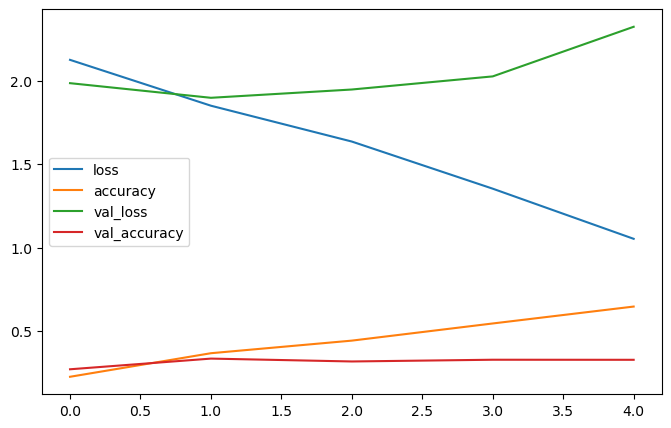

In [22]:
pd.DataFrame(m2History.history).plot(figsize=(8, 5));

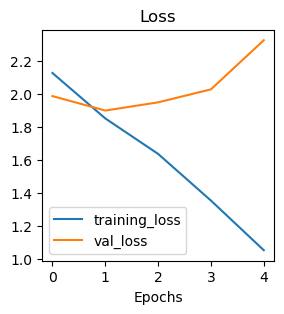

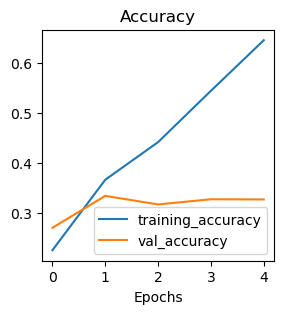

In [23]:
plot_loss_curves(m2History)

#### Adjust Model: Data Augmentation
## Model III: Data Augmentation
### Augment Data

In [75]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis

# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)

# 
# will re-use "train_datagen" from above
# 

# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)

# Import data and augment the data from training directory
print("Augmented training images:")
train_data_augmented = train_datagen_augmented.flow_from_directory(training_dir_path,
                                                                   target_size=(224, 224),
                                                                   batch_size=batchSize,
                                                                   class_mode='categorical',
                                                                   shuffle=True)

# Create non-augmented data batches
print("Non-augmented training images:")
train_data = train_datagen.flow_from_directory(training_dir_path,
                                               target_size=(224, 224),
                                               batch_size=batchSize,
                                               class_mode='categorical',
                                               shuffle=False) # Don't shuffle for demonstration purposes

print("Unchanged test images:")
test_data = test_datagen.flow_from_directory(testing_dir_path,
                                             target_size=(224, 224),
                                             batch_size=batchSize,
                                             class_mode='categorical')

Augmented training images:
Found 7500 images belonging to 10 classes.
Non-augmented training images:
Found 7500 images belonging to 10 classes.
Unchanged test images:
Found 2500 images belonging to 10 classes.


### Preview some Augmented Images

In [79]:
# get data to preview
images, labels = augmented_train_data.next()
augmented_images, augmented_labels = train_data_augmented.next() # Note: labels aren't augmented, they stay the same

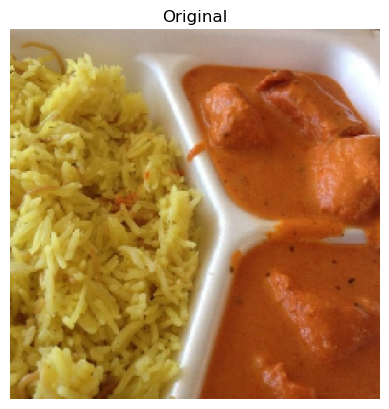

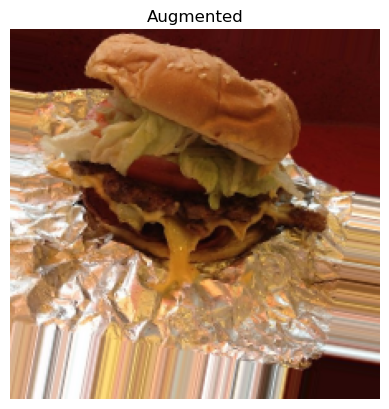

In [80]:
random_number = random.randint(0, 31) # we're making batches of size 32, so we'll get a random instance

# 
# Show original image and augmented image
# 
plt.imshow(images[random_number])
plt.title(f"Original")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented")
plt.axis(False);

### Build Model
This is the same as the "baseline", but with augmented data instead of the starting data

In [81]:
# 
# Create
# 
# based on the TinyVGG model
# https://github.com/poloclub/cnn-explainer/blob/master/tiny-vgg/tiny-vgg.py#L179
augmentedModel = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(outputUnitCount, activation='softmax')
])

In [82]:

# 
# Compile
# 
augmentedModel.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [83]:
# 
# FIT
# 
augmentedModelHistory = augmentedModel.fit(train_data_augmented,
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=testing_data,
                        validation_steps=len(testing_data))

Epoch 1/5
469/469 [==============================] - 1209s 3s/step - loss: 2.2086 - accuracy: 0.1731 - val_loss: 2.0849 - val_accuracy: 0.2584
Epoch 2/5
469/469 [==============================] - 1255s 3s/step - loss: 2.0832 - accuracy: 0.2501 - val_loss: 1.9280 - val_accuracy: 0.3080
Epoch 3/5
469/469 [==============================] - 1203s 3s/step - loss: 2.0013 - accuracy: 0.2929 - val_loss: 1.8401 - val_accuracy: 0.3780
Epoch 4/5
469/469 [==============================] - 1195s 3s/step - loss: 1.9687 - accuracy: 0.3149 - val_loss: 1.8220 - val_accuracy: 0.3720
Epoch 5/5
469/469 [==============================] - 1197s 3s/step - loss: 1.9403 - accuracy: 0.3257 - val_loss: 1.7761 - val_accuracy: 0.3860


### Inspect Results
#### Summary

In [85]:
augmentedModel.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_43 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 110, 110, 10)      0         
 ng2D)                                                           
                                                                 
 conv2d_44 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_45 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 53, 53, 10)        0         
 ng2D)                                               

#### Visualize loss & Accuracy

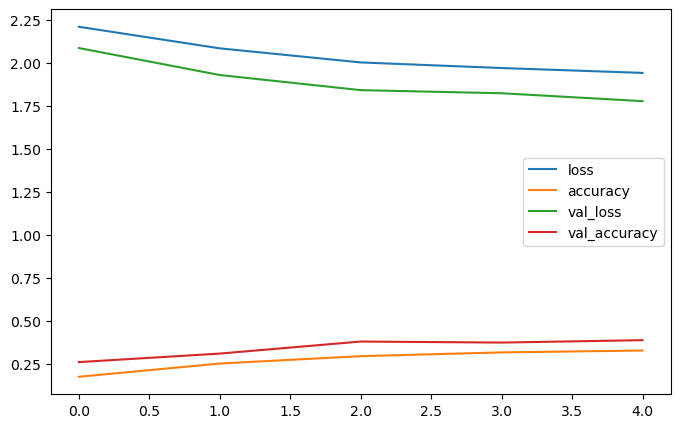

In [90]:
pd.DataFrame(augmentedModelHistory.history).plot(figsize=(8, 5));

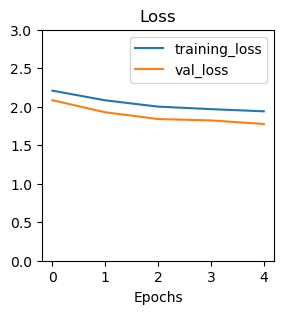

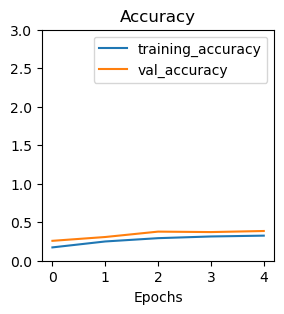

In [95]:
plot_loss_curves(augmentedModelHistory)